# Notebook to generate RAS maps - pinkbombs
## PROVISIONAL

#### General imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement
from folium.plugins import GroupedLayerControl

In [4]:
import zipfile 
import os 

In [5]:
import fiona 
import geopandas as gpd 
from bs4 import BeautifulSoup 

In [6]:
import requests

## 1 - Inputs

### 1.1 - RAS dataset adapted from Esther (Google Sheet)
Here we use the dataset put together by Esther and modified/expanded by Antoine/Sarah/Paul (see link to Google Drive below). The dataset was also checked again by Esther (Seastemik) and Gauthier (Welfarm).

https://docs.google.com/spreadsheets/d/1vtZzw8y8IrfWjK2ItR33ApJ0ww10r7_n/edit?usp=sharing&ouid=113313479374754815448&rtpof=true&sd=true

In [7]:
# Load adapted dataset - download from Google sheet
ras_file = "data_ras/Projets RAS Locations.xlsx - RAS.csv" 
projets_ras = pd.read_csv(ras_file) #, encoding='unicode_escape')

In [8]:
projets_ras.columns.values
projets_ras.shape

(150, 27)

In [9]:
projets_ras.head(3)

Company       Parent company  \
0                      Andfjord Salmon  (Kvalnes)       Andfjord Salmon   
1                                Atlantic Sapphire    Atlantic Sapphire   
2  Sotenas Marine Park (previously Quality Salmon)  Sotenas Marine Park   

  Production moyenne Production Max Saved Production Max Abattage  \
0                NaN         39,000                  NaN     non    
1              1,000        200,000                  NaN     oui    
2                NaN        100,000                  NaN     non    

                                               Infos  \
0   passage à la phase 2 càd de 1000 à 19000 tonn...   
1  https://www.fishfarmingexpert.com/atlantic-sap...   
2  https://www.seafoodsource.com/news/aquaculture...   

                                 Link info (no text) Technologie  \
0                                                NaN         FTS   
1  https://www.seafoodsource.com/news/aquaculture...         RAS   
2  https://www.intrafish.com/salmon/most-definite...         RAS   

   Etat d'avancement  ...        Country            Location  \
0  En fonctionnement  ...         Norway     Kvalnes, Andøya   
1  En fonctionnement  ...  United States   Homstead, Florida   
2         Conceptuel  ...         Sweden  Sotenäs, Kungshamn   

  Matching Location                   Comment on location  \
0           Kvalnes                                   NaN   
1               NaN  Homstead, Miami-Dade County, Florida   
2         Kungshamn                                   NaN   

                                     Location source   Latitude  Longitude  \
0                                                NaN  69.158148  16.093888   
1  https://www.fishfarmingexpert.com/atlantic-sap...  25.468759 -80.481078   
2  https://www.seafoodsource.com/news/aquaculture...        NaN        NaN   

                                        Errors found Duplicate Exclude  
0     C'est du FTS (Flow Through Systems) et pas RAS       NaN     yes  
1  Correct production from 9,500 to 200,000 based...       NaN     NaN  
2                                                NaN       NaN     NaN  

[3 rows x 27 columns]

### 1.2 - Carbon emissions by country for Data enrichment  
To represent the carbon footprint on the map, we bring a publicaly available dataset on Carbon intensity by country

https://ourworldindata.org/grapher/carbon-intensity-electricity?tab=table

In [10]:
# Load data for Carbon intensity of electricity generation by country
carbon_file = "data_ras/carbon-intensity-electricity.csv" 
carbon_elec = pd.read_csv(carbon_file) 

In [12]:
# For each country, take most recent data point (2022, if not 2021,...)
carbon_elec22 = carbon_elec.loc[carbon_elec.groupby('Entity').Year.idxmax()]
#carbon_elec22 = carbon_elec.loc[carbon_elec['Year'] == 2022,]
carbon_elec22.head(3)

Entity Code  Year  Carbon intensity of electricity - gCO2/kWh
22  ASEAN (Ember)  NaN  2022                                  508.204220
44    Afghanistan  AFG  2021                                  120.481926
66         Africa  NaN  2021                                  484.696530

In [13]:
# Show the key countries of interest
#carbon_elec22.sort_values('Carbon intensity of electricity - gCO2/kWh', ascending=False).head(10)
carbon_elec22.loc[carbon_elec22.Entity.isin(['Norway', 'United States', 'France', 
                                             'Portugal', 'China', 'United Kingdom', 
                                             'Iceland', 'Saudi Arabia']), ].sort_values('Carbon intensity of electricity - gCO2/kWh', 
                                                                                        ascending=False)

Entity Code  Year  Carbon intensity of electricity - gCO2/kWh
4114    Saudi Arabia  SAU  2022                                  557.782800
982            China  CHN  2022                                  533.982800
4911   United States  USA  2022                                  368.101960
4888  United Kingdom  GBR  2022                                  261.154900
3834        Portugal  PRT  2022                                  234.604720
1696          France  FRA  2022                                   84.879000
3541          Norway  NOR  2022                                   28.924809
2210         Iceland  ISL  2021                                   28.556593

In [14]:
## Merge with RAS dataset
projets_ras = projets_ras.merge(carbon_elec22, left_on='Country', right_on='Entity', how='left')
#projets_ras.head()

### 1.3 - Conversion parameters
We need conversion parameters to calculate the electricity consumption of individual farms, based on their production. Also to calculate the carbon footprint for individual farms.

#### 1.3.1 - Electricity consumption
Given the uncertainty, we use a range for the electricity consumption per kg of salmon produced. Both are from peer-reviewed publications:
- Lower estimate: 9.59 kWh/kg salmon Ayuso-Virgili et al. 2023 https://www.sciencedirect.com/science/article/pii/S0144860923000171 
- Upper estimate: 22.6 kWh/kg salmon Ayer et al. 2009 https://www.sciencedirect.com/science/article/abs/pii/S0959652608001820

In [21]:
# Electricity consumption per kg of salmon produced
elec_per_kg_low = 9.59   #kWh/kg == 9.59 * 1000 kWh / tonnes
elec_per_kg_high = 22.6  #kWh/kg == 22.6 * 1000 kWh / tonnes

In [22]:
# Convert Production to integer
projets_ras['Production Max'] = projets_ras['Production Max'].apply(lambda x: np.nan if pd.isna(x) else int(x.replace(',','')))

# Calculate Electricity consumption for each farm - low and high
projets_ras['elec_conso_kWh_low'] = projets_ras['Production Max'] * elec_per_kg_low * 1000
projets_ras['elec_conso_kWh_high'] = projets_ras['Production Max'] * elec_per_kg_high * 1000

#### 1.3.2 - Carbon footprint
The carbon footprint of individual farms was estimated based of four components:
1. Emissions from salmon feeds: 2.64 kgCO2/kg salmon - Sustainability report Biomar (2022) - LINK TO ADD
2. Emissions from the construction phase: 0.39 kgCO2/kg salmon - LINK TO ADD
3. Emissions from oxygenation : 0.44 kgCO/kg salmon - Liu et al. 2016 https://www.sciencedirect.com/science/article/pii/S0144860916300036#fig0015
4. Emissions from the salmon life cycle in land-based farms, using the emissions from electricity consumption in the country where the farm is located, based on the “Carbon intensity of electricity generation” dataset (2023)

In [23]:
# Carbon footprint of farmed salmon 3 components
carbon_per_kg_feed = 2.64       #kg C02 equ / kg LW == t C02 / t LW 
carbon_per_kg_construc = 0.39   #kg C02 equ / kg LW == t C02 / t LW 
carbon_per_kg_oxygen = 0.44     #kg C02 equ / kg LW == t C02 / t LW
carbon_per_kg_compo123 = carbon_per_kg_feed + carbon_per_kg_construc + carbon_per_kg_oxygen
carbon_per_kg_compo123

3.47

So the conversion factor for the components of 1. feed, 2. contruction, 3. oxygenation represent 3.47 kgC02/kg.
We need to calculate the conversion factor for electricity

In [46]:
# Let's examine the conversion factor for key countries of interest
carbon_elec22_key = carbon_elec22.loc[carbon_elec22.Entity.isin(['Norway', 'United States', 'France', 
                                             'Portugal', 'China', 'United Kingdom', 
                                             'Iceland', 'Saudi Arabia']), ].sort_values('Carbon intensity of electricity - gCO2/kWh', 
                                                                                        ascending=False)
carbon_elec22_key['carbon_kg_low'] = elec_per_kg_low * carbon_elec22_key['Carbon intensity of electricity - gCO2/kWh'] /1000 # kgCO2/kg
carbon_elec22_key['carbon_kg_high'] = elec_per_kg_high * carbon_elec22_key['Carbon intensity of electricity - gCO2/kWh'] /1000 # kgCO2/kg
#carbon_elec22_key['carbon_per_kg_compo123'] = carbon_per_kg_compo123
carbon_elec22_key['carbon_per_kg_feed'] = carbon_per_kg_feed 
carbon_elec22_key['carbon_per_kg_construc'] = carbon_per_kg_construc
carbon_elec22_key['carbon_per_kg_oxygen'] = carbon_per_kg_oxygen
carbon_elec22_key

Entity Code  Year  Carbon intensity of electricity - gCO2/kWh  \
4114    Saudi Arabia  SAU  2022                                  557.782800   
982            China  CHN  2022                                  533.982800   
4911   United States  USA  2022                                  368.101960   
4888  United Kingdom  GBR  2022                                  261.154900   
3834        Portugal  PRT  2022                                  234.604720   
1696          France  FRA  2022                                   84.879000   
3541          Norway  NOR  2022                                   28.924809   
2210         Iceland  ISL  2021                                   28.556593   

      carbon_kg_low  carbon_kg_high  carbon_per_kg_feed  \
4114       5.349137       12.605891                2.64   
982        5.120895       12.068011                2.64   
4911       3.530098        8.319104                2.64   
4888       2.504475        5.902101                2.64   
3834       2.249859        5.302067                2.64   
1696       0.813990        1.918265                2.64   
3541       0.277389        0.653701                2.64   
2210       0.273858        0.645379                2.64   

      carbon_per_kg_construc  carbon_per_kg_oxygen  
4114                    0.39                  0.44  
982                     0.39                  0.44  
4911                    0.39                  0.44  
4888                    0.39                  0.44  
3834                    0.39                  0.44  
1696                    0.39                  0.44  
3541                    0.39                  0.44  
2210                    0.39                  0.44

In [24]:
# Calculate CO2 emissions for each farm from Electricity consumption of country for each farm - low and high
# convert g CO2 into kilotons CO2 (divide by 1e9)
projets_ras['carbon_elec_kt_low'] = projets_ras['elec_conso_kWh_low'] * projets_ras['Carbon intensity of electricity - gCO2/kWh']/1e9
projets_ras['carbon_elec_kt_high'] = projets_ras['elec_conso_kWh_high'] * projets_ras['Carbon intensity of electricity - gCO2/kWh']/1e9

In [28]:
# Calculate carbon footprint for all 4 components (electricity and 1,2,3) - low and high
# convert t CO2 into kilotons CO2 (divide by 1000)
projets_ras['carbon_kt_low'] =  projets_ras['carbon_elec_kt_low'] + projets_ras['Production Max'] * carbon_per_kg_compo123 /1000
projets_ras['carbon_kt_high'] =  projets_ras['carbon_elec_kt_high'] + projets_ras['Production Max'] * carbon_per_kg_compo123 /1000

In [34]:
# Check 
projets_ras[['Parent company','Country', 'Carbon intensity of electricity - gCO2/kWh', 
             'Production Max', 'elec_conso_kWh_low', 'elec_conso_kWh_high', 
             'carbon_elec_kt_low', 'carbon_elec_kt_high', 'carbon_kt_low', 'carbon_kt_high']].head(15)

Parent company               Country  \
0               Andfjord Salmon                Norway   
1             Atlantic Sapphire         United States   
2           Sotenas Marine Park                Sweden   
3           Sotenas Marine Park                Sweden   
4                  Maiken Foods              Portugal   
5     Norwegian Mountain Salmon        United Kingdom   
6            West Coast Salmon          United States   
7               Andfjord Salmon                Norway   
8               Andfjord Salmon                Norway   
9     Ardal Aqua, Grieg Seafood                Norway   
10               Arctic Seafarm                Norway   
11               Viking Labels   United Arab Emirates   
12                 Whole Oceans         United States   
13  Asset Buyout Partners (ABP)                Norway   
14         Averoy Industripark                 Norway   

    Carbon intensity of electricity - gCO2/kWh  Production Max  \
0                                    28.924809         39000.0   
1                                   368.101960        200000.0   
2                                    45.119328        100000.0   
3                                    45.119328             NaN   
4                                   234.604720        100000.0   
5                                   261.154900         90000.0   
6                                   368.101960         60000.0   
7                                    28.924809         25000.0   
8                                    28.924809         25000.0   
9                                    28.924809         15000.0   
10                                   28.924809         15000.0   
11                                  407.974670         50000.0   
12                                  368.101960         50000.0   
13                                   28.924809         42000.0   
14                                   28.924809         20000.0   

    elec_conso_kWh_low  elec_conso_kWh_high  carbon_elec_kt_low  \
0         3.740100e+08         8.814000e+08           10.818168   
1         1.918000e+09         4.520000e+09          706.019559   
2         9.590000e+08         2.260000e+09           43.269436   
3                  NaN                  NaN                 NaN   
4         9.590000e+08         2.260000e+09          224.985926   
5         8.631000e+08         2.034000e+09          225.402794   
6         5.754000e+08         1.356000e+09          211.805868   
7         2.397500e+08         5.650000e+08            6.934723   
8         2.397500e+08         5.650000e+08            6.934723   
9         1.438500e+08         3.390000e+08            4.160834   
10        1.438500e+08         3.390000e+08            4.160834   
11        4.795000e+08         1.130000e+09          195.623854   
12        4.795000e+08         1.130000e+09          176.504890   
13        4.027800e+08         9.492000e+08           11.650335   
14        1.918000e+08         4.520000e+08            5.547778   

    carbon_elec_kt_high  carbon_kt_low  carbon_kt_high  
0             25.494327     146.148168      160.824327  
1           1663.820859    1400.019559     2357.820859  
2            101.969681     390.269436      448.969681  
3                   NaN            NaN             NaN  
4            530.206667     571.985926      877.206667  
5            531.189067     537.702794      843.489067  
6            499.146258     420.005868      707.346258  
7             16.342517      93.684723      103.092517  
8             16.342517      93.684723      103.092517  
9              9.805510      56.210834       61.855510  
10             9.805510      56.210834       61.855510  
11           461.011377     369.123854      634.511377  
12           415.955215     350.004890      589.455215  
13            27.455429     157.390335      173.195429  
14            13.074014      74.947778       82.474014

#### 1.3.3 - NOT USED
The conversion factors between production and C02 emissions are no longer used as it will vary from country to country
- 10 FULL SUPPLY CHAIN inc. transport - WWF - https://www.worldwildlife.org/publications/measuring-and-mitigating-ghgs-salmon
- 5.77 - Agribalyse - https://agribalyse.ademe.fr/app/aliments/26036#Saumon,_cru,_élevage
- 57 - Land-based - Compassion in Animal Farming - CIWF, International Salmon Farmers Association (2015) The evolution of land based Atlantic salmon farms

In [66]:
### NOT USED ####
# Carbon footprint of farmed salmon
#carbon_per_kg = 57 #kg C02 equ / kg LW == 57t C02 / t LW 
# Calculate CO2 emissions directly from production for each farm -- NOT USED
#projets_ras['carbon_footprint_t'] = projets_ras['Production Max']*carbon_per_kg

### 1.4 - Data Filtering - SCOPE
Here we implement the agreed scope for the map:
- Technology: RAS and Hybrid, SIFT, excluding FTS
- Species: only Salmon species, so excluding Yellowtail, Shrimp, Trout, Kingfish, Steelhead trout, Rainbow trout
- Etat d'avancement: All status except those abandonned or stopped (arret).
- Duplicate: Remove all lines labelled duplicates but kept in the spreadsheet to avoid deleting information before next update
- Exclude: farm marked as exclude because duplicated or other reason

In [69]:
# For farms with no entry in Species, set to 'Atlantic Salmon'
projets_ras['Species'] = np.where(projets_ras['Species'].isna(), 'Atlantic Salmon', projets_ras['Species'])

In [70]:
# Define criteria lists
techno_no = ['FTS']
species_no = ['Yellow tail', 'Kingfish tail', 'Shrimp', 
              'Smolt', 'Smolt and trout', 'Patagonia King Salmon smolt', 
              'Trout', 'Steelhead trout', 'Rainbow trout', 
              'Barramundi and Himalayan Rainbow Trout',
              'Royal Sea Bream and Sea Brass']
etat_no = ['Abandon', 'Arrêt']

In [71]:
#projets_ras["Species"].value_counts()
#projets_ras["Technologie"].value_counts()
#projets_ras["Exclude"].value_counts()

In [72]:
# Summary of what we exclude and why
excluded = {'Exclude_yes': sum(projets_ras['Exclude'] == 'yes'),
            'Duplicate_yes': sum(projets_ras['Duplicate'] == 'yes'),
            'Techno': sum(projets_ras['Technologie'].isin(techno_no)),
            'Species': sum(projets_ras['Species'].isin(species_no)),
            'Etat': sum(projets_ras["Etat d'avancement"].isin(etat_no)),
            'Duplicate and techno, species and etat': sum(
                (projets_ras['Duplicate'] == 'yes') | 
                (projets_ras['Technologie'].isin(techno_no)) |
                (projets_ras['Species'].isin(species_no)) |
                (projets_ras["Etat d'avancement"].isin(etat_no)))}
excluded

{'Exclude_yes': 40,
 'Duplicate_yes': 12,
 'Techno': 8,
 'Species': 16,
 'Etat': 9,
 'Duplicate and techno, species and etat': 40}

>This is rassuring, combining the 4 exclusion criteria (duplicates, FTS technology, Non salmon species and non Abandon/Arret leads to the same number as using the "Exclude" column from the Spreadsheet

In [73]:
projets_ras = projets_ras.loc[(projets_ras['Duplicate'] != 'yes') & 
            (~projets_ras['Technologie'].isin(techno_no)) &
            (~projets_ras['Species'].isin(species_no)) & 
            (~projets_ras["Etat d'avancement"].isin(etat_no)),]

In [74]:
projets_ras.shape

(110, 33)

### <font color='red'>110 (4 as ambitions) == 106 - Same as spreadsheet!</font> 

In [75]:
projets_ras["Species"].value_counts() ## To change in spreadsheet!!! 

Species
Atlantic Salmon                                                95
Not specified                                                   2
King Salmon                                                     2
Coho Salmon                                                     2
Atlantic Salmon and non-salmonoids                              1
Rainbow Trout and Atlantic Salmon                               1
Atlantic Cod and Atlantic Salmon Smolt                          1
Atlantic Salmon (OGM)                                           1
Atlantic Salmon, Coho Salmon, King Salmon and Rainbow Trout     1
Atlantic Salmon and Steelhead Trout                             1
Pacific Salmon and Shrimp                                       1
Atlantic Salmon and Rainbow Trout                               1
Sockeye Salmon                                                  1
Name: count, dtype: int64

## 2 - Exploratory Data Analysis

### 2.1 - Status

In [76]:
# Map fields into english
projets_ras['Detailed status'] = projets_ras["Etat d'avancement"].map({'En construction': 'In construction', 
                                                                       'En fonctionnement': 'Operating',
                                                                       'Blocage Opposition': 'Local opposition',
                                                                       'Blocage financier': 'Financial block',
                                                                       'Bloquage législatif': 'Legal block',
                                                                       'Conceptuel': 'Conceptual',
                                                                       'Permis': 'Permit',
                                                                       'No project yet': 'No project yet'})

In [77]:
#projets_ras.groupby(["Detailed status", "Etat d'avancement"]).size()

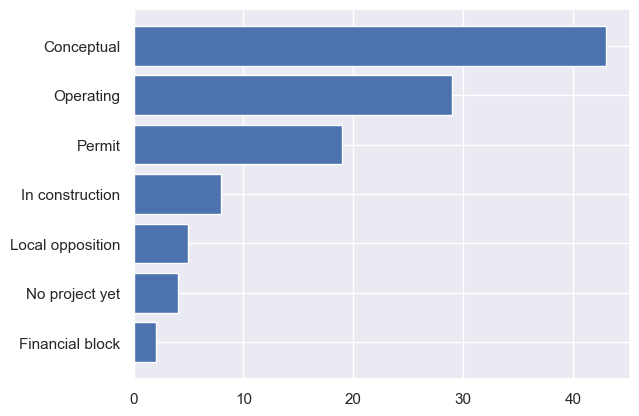

In [78]:
# Histogram of stages
df = projets_ras['Detailed status'].value_counts().reset_index().sort_values(by=['count'])
plt.barh(y=df['Detailed status'], width=df['count'])
plt.show()

In [79]:
# Categorise Detailed status into 3 status in english
concept = ['Local opposition', 'Financial block', 'Legal block', 'Conceptual', 'Permit']
projets_ras['Status'] = np.where(projets_ras['Detailed status'].isin(concept), 'Project', projets_ras['Detailed status'])
projets_ras.groupby(["Status", 'Detailed status']).size()

Status           Detailed status 
In construction  In construction      8
No project yet   No project yet       4
Operating        Operating           29
Project          Conceptual          43
                 Financial block      2
                 Local opposition     5
                 Permit              19
dtype: int64

In [80]:
# Aggregate the table by countries and detailed status
ras_country = projets_ras.groupby(["Country", "Detailed status"]).size().reset_index()
ras_country.columns = ["Country", "Detailed status", "count"]
ras_country = ras_country.pivot_table(values='count', index=['Country'], columns=["Detailed status"], aggfunc="sum").fillna(0).reset_index()

In [81]:
# Caluclate total number of farms for each country
col_sum = ['In construction', 'Operating','Local opposition', 'Financial block', 'Conceptual', 'Permit']
ras_country['tot_ras_farms'] = ras_country[col_sum].sum(axis=1)
ras_country.sort_values('tot_ras_farms', ascending=False).head()

Detailed status        Country  Conceptual  Financial block  In construction  \
13                      Norway         7.0              1.0              3.0   
27               United States         3.0              1.0              1.0   
4                        China         3.0              0.0              0.0   
9                        Japan         2.0              0.0              1.0   
16                      Russia         4.0              0.0              1.0   

Detailed status  Local opposition  No project yet  Operating  Permit  \
13                            0.0             0.0        6.0    16.0   
27                            2.0             0.0        4.0     0.0   
4                             0.0             1.0        4.0     0.0   
9                             0.0             0.0        2.0     0.0   
16                            0.0             0.0        0.0     0.0   

Detailed status  tot_ras_farms  
13                        33.0  
27                        11.0  
4                          7.0  
9                          5.0  
16                         5.0

### 2.2 - Energy Consumption

Text(0, 0.5, 'Number of farms')

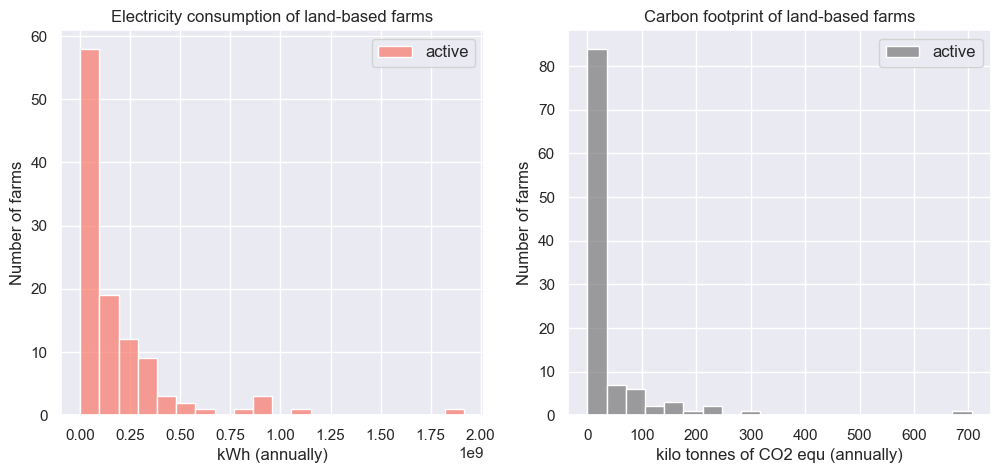

In [82]:
# Histogram of Elec conso & Carbon footprint
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.set(style="darkgrid")
sns.histplot(projets_ras['elec_conso_kWh'], label='active', bins=20, color="salmon", ax = axs[0])
axs[0].legend(prop={'size': 12})
axs[0].set_title('Electricity consumption of land-based farms')
axs[0].set_xlabel('kWh (annually)')
axs[0].set_ylabel('Number of farms')

sns.histplot(projets_ras['carbon_elec_kt'], label='active', bins=20, color="gray", ax = axs[1])
axs[1].legend(prop={'size': 12})
axs[1].set_title('Carbon footprint of land-based farms')
axs[1].set_xlabel('kilo tonnes of CO2 equ (annually)')
axs[1].set_ylabel('Number of farms')

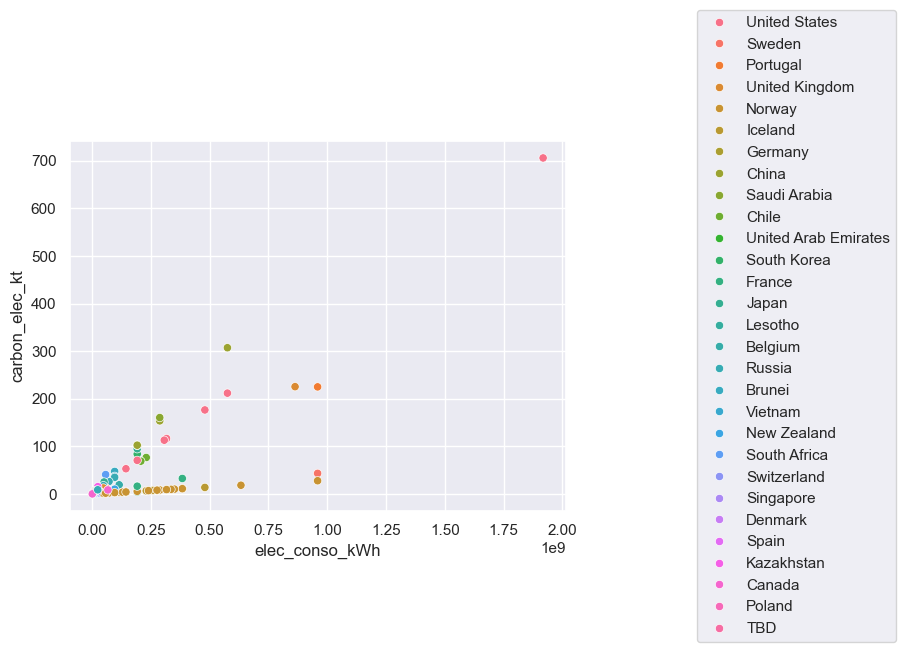

In [83]:
## Plot Carbon footprint vs. elec production
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.scatterplot(data=projets_ras, x='elec_conso_kWh', y='carbon_elec_kt', hue='Country', ax = axs)
axs.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

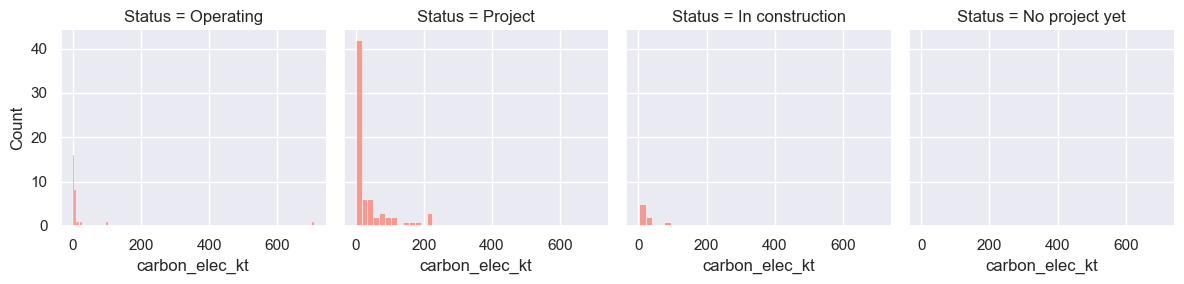

In [85]:
g = sns.FacetGrid(projets_ras, col="Status")
g.map(sns.histplot, 'carbon_elec_kt', color="salmon")

## 3 - Transform dataset into geospatial
The manual data collection involves finding the village/town of the farm, which can be associated with coordinates (Latitude, Longitude) automatically using the opendatasoft database for town > 1000 inhabitants (link below). For the farms in smaller village or if the town has a too common name, the coordinates were entered manually using Google maps. As a result, in this section, we bring the coordinates for part of the dataset, create geopandas datasets and join them back together.

https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/json?lang=en&timezone=Europe%2FBerlin

In [86]:
# Load coordinates dataset 
cities = gpd.read_file('data_ras/geonames-all-cities-with-a-population-1000.geojson')
#cities.head()

In [87]:
#cities.cou_name_en.value_counts().reset_index().head(50)

In [88]:
# New column for country names to match geo dataset
projets_ras['CountryG'] = projets_ras['Country']
projets_ras.loc[projets_ras['CountryG'] == 'Russia', 'CountryG'] = 'Russian Federation'
projets_ras.loc[projets_ras['CountryG'] == 'Vietnam', 'CountryG'] = 'Viet Nam'
projets_ras.loc[projets_ras['CountryG'] == 'Brunei', 'CountryG'] = 'Brunei Darussalam'

### 3.1 - Part 1
Farms with existing Lat/Long coordinates in the input file

In [89]:
# PART 1 - Farms with LatLong coord
projets_ras_co1 = projets_ras.loc[projets_ras['Latitude'].isna() == False,]
projets_ras_co1.shape

(70, 36)

In [90]:
# Create geopandas
projets_ras_co1_gpd = gpd.GeoDataFrame(projets_ras_co1,
                                 geometry=gpd.points_from_xy(projets_ras_co1['Longitude'], projets_ras_co1['Latitude']), 
                                 crs="EPSG:4326")
projets_ras_co1_gpd.head(3)
#projets_ras_co1_gpd.shape

Company             Parent company Production moyenne  \
1          Atlantic Sapphire          Atlantic Sapphire              1,000   
5  Norwegian Mountain Salmon  Norwegian Mountain Salmon                NaN   
9                 Ardal Aqua  Ardal Aqua, Grieg Seafood                NaN   

   Production Max Saved Production Max Abattage  \
1        200000.0                  NaN     oui    
5         90000.0                  NaN      NaN   
9         15000.0                3,000     non    

                                               Infos  \
1  https://www.fishfarmingexpert.com/atlantic-sap...   
5  https://thefishsite.com/articles/is-lewis-set-...   
9  https://www.seafoodsource.com/news/aquaculture...   

                                 Link info (no text)     Technologie  \
1  https://www.seafoodsource.com/news/aquaculture...             RAS   
5  https://thefishsite.com/articles/is-lewis-set-...  Hybrid FTS/RAS   
9  https://www.seafoodsource.com/news/aquaculture...             RAS   

   Etat d'avancement  ...          Entity Code    Year  \
1  En fonctionnement  ...   United States  USA  2022.0   
5         Conceptuel  ...  United Kingdom  GBR  2022.0   
9    En construction  ...          Norway  NOR  2022.0   

  Carbon intensity of electricity - gCO2/kWh elec_conso_kWh carbon_elec_kt  \
1                                 368.101960   1.918000e+09     706.019559   
5                                 261.154900   8.631000e+08     225.402794   
9                                  28.924809   1.438500e+08       4.160834   

   Detailed status           Status        CountryG  \
1        Operating        Operating   United States   
5       Conceptual          Project  United Kingdom   
9  In construction  In construction          Norway   

                     geometry  
1  POINT (-80.48108 25.46876)  
5   POINT (-7.10202 58.10483)  
9    POINT (6.16721 59.15153)  

[3 rows x 37 columns]

In [91]:
#sum(projets_ras_co1_gpd['geometry'].isna())

### 3.2 - Part 2
Farms where we need to match the location. We only use regular matching here against the Matching location and country. No fuzzy matching is implemented.

In [92]:
# Check data issues
projets_ras.loc[(projets_ras['Location'].isna()) & (projets_ras['Latitude'].isna()),
['Company', 'Parent company', 'Technologie', "Etat d'avancement", 'Location','Matching Location', 'Latitude','Errors found','Exclude']]

Empty DataFrame
Columns: [Company, Parent company, Technologie, Etat d'avancement, Location, Matching Location, Latitude, Errors found, Exclude]
Index: []

In [93]:
# Part 2 - Farms with no coordinates but locations  --> simple matching
projets_ras_loc = projets_ras.loc[(projets_ras['Location'].isna() == False) & (projets_ras['Latitude'].isna()),]

In [94]:
# Merge geometry to original dataset
#projets_ras_locxy = projets_ras_loc.merge(cities_sub[['name', 'geometry']], left_on='Location', right_on='name', how='left')
#type(projets_ras_locxy)

In [95]:
# Match on location AND country
projets_ras_locxyB = projets_ras_loc.merge(cities[['name', 'cou_name_en', 'geometry']], how='left',
                                           left_on=['Matching Location', 'CountryG'], 
                                           right_on=['name', 'cou_name_en'])

In [96]:
# How many not found?
sum(projets_ras_locxyB['name'].isna())

4

In [97]:
## Show those not found through matching
projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna(),['Company', 'Country', 'CountryG', 'Location', 'Matching Location', 
                                                          'Comment on location', 'name', 'geometry']]

Company Country CountryG           Location  \
36              Pure Salmon     TBD      TBD                TBD   
37         Proximar Seafood     TBD      TBD                TBD   
38  Qingdao Guoxin (bateau)   China    China  Yellow Sea (ship)   
39         Salmon Evolution     TBD      TBD                TBD   

   Matching Location Comment on location name geometry  
36               NaN                 NaN  NaN     None  
37               NaN                 NaN  NaN     None  
38               NaN                 NaN  NaN     None  
39               NaN                 NaN  NaN     None

This is expected at the 4 lines with ambitions don't have locations and won't appear on the map

In [98]:
# Set dataframe for part 2 dropping the 2 columns not in part 1
#projets_ras_co2 = projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna() == False,].drop(columns=['name', 'cou_name_en'])

# Keep the ambitions here
projets_ras_co2 = projets_ras_locxyB.drop(columns=['name', 'cou_name_en'])

In [99]:
#projets_ras_co2.columns.values
projets_ras_co2.shape

(40, 37)

In [100]:
# Put into GeoDataFrame
projets_ras_co2_gpd = gpd.GeoDataFrame(projets_ras_co2)
#projets_ras_co2_gpd.head()

### 3.3 - Combine Part 1 and 2 and checks
Here we combine the 2 geodataframes together and check that all the farms in scope (Section 2) have the fields required for mapping (Lat/Long) and for display on the pop-up windows. 

In [141]:
# Combine Part 1 and Part 2
projets_ras_co_gpd = pd.concat([projets_ras_co1_gpd, projets_ras_co2_gpd]).reset_index()

In [142]:
projets_ras_co_gpd.tail(3)

index                  Company    Parent company Production moyenne  \
107     37         Proximar Seafood  Proximar Seafood                NaN   
108     38  Qingdao Guoxin (bateau)    Qingdao Guoxin                NaN   
109     39         Salmon Evolution  Salmon Evolution                NaN   

     Production Max Saved Production Max Abattage  \
107         20700.0                  NaN      NaN   
108         60000.0                  NaN     oui    
109         19200.0                  NaN      NaN   

                                                 Infos  \
107  Proximar has blue sky ambitions of 26,000 (nor...   
108  dinguerie chinoise, trois bateaux pour élever ...   
109  Production target of 100,000 tonnes by 2032, w...   

                                   Link info (no text) Technologie  ...  \
107  https://norne.no/wp-content/uploads/2023/01/La...         RAS  ...   
108  https://www.fishfarmingexpert.com/8f-asset-man...         RAS  ...   
109  https://www.rastechmagazine.com/salmon-evoluti...         RAS  ...   

    Entity Code    Year Carbon intensity of electricity - gCO2/kWh  \
107    NaN  NaN     NaN                                        NaN   
108  China  CHN  2022.0                                   533.9828   
109    NaN  NaN     NaN                                        NaN   

    elec_conso_kWh carbon_elec_kt Detailed status          Status CountryG  \
107    198513000.0            NaN  No project yet  No project yet      TBD   
108    575400000.0     307.253703  No project yet  No project yet    China   
109    184128000.0            NaN  No project yet  No project yet      TBD   

    geometry  
107     None  
108     None  
109     None  

[3 rows x 38 columns]

In [143]:
projets_ras_co_gpd.shape

(110, 38)

In [144]:
# To save dataset as csv and construct map elsewhere, we save the lat/long or y/x for all
projets_ras_co_gpd['Lat'] = projets_ras_co_gpd['geometry'].y
projets_ras_co_gpd['Long'] = projets_ras_co_gpd['geometry'].x

In [145]:
#projets_ras_co_gpd[['Lat', 'Long', 'Latitude', 'Longitude', 'geometry']]

In [146]:
#projets_ras_co_gpd.columns.values

In [147]:
# Checks where data is missing 
needed = ['Parent company', 'Production Max', 'Link info (no text)', 'Technologie', 'Species', 
              'Latest update', 'Country', 'Location', 'Location source', 
              'Carbon intensity of electricity - gCO2/kWh', 
              'elec_conso_kWh',
              'carbon_elec_kt', 
              'Detailed status', 'Status', 'Lat', 'Long']  
#Should 0 everywhere, except for the 4 ambitions
#projets_ras_co_gpd[needed].isna().sum()

### 3.4 - Save outputs for pinkbombs Dashboard (current) pipeline
Here we need to save the datasets with the fields required so it can be put on Github and be publically available. This dataset needs to be able to re-generate the map for the Dashboard on the pinkbombs website. In addition, we do an aggregation by company and save the top producers for another figure for the Dashboard.

In [148]:
# Output the data as csv - only what is needed for the map
projets_ras_co_gpd[needed].to_csv("data_ras/Projets RAS Locations_manipulated.csv")

In [149]:
# Aggreate by parent company
projets_ras_company = projets_ras_co_gpd.groupby('Parent company').agg({'Production Max': 'sum',
                                                                        'Company': 'count',
                                                                        'Country': 'unique'}).reset_index()
projets_ras_company['Countries of projects'] = projets_ras_company['Country'].apply(lambda x: ', '.join(x))
projets_ras_company['Production Max'] = projets_ras_company['Production Max'].astype('int')
projets_ras_company = projets_ras_company.rename(columns={'Company': 'Number of projects',
                                                         'Production Max': 'Production in tonnes'}).drop(columns=['Country'])

In [150]:
# Top 10 are companies with > 50,000 tonnes production ambitions
projets_ras_company.sort_values('Production in tonnes', ascending=False).head(12)

Parent company  Production in tonnes  Number of projects  \
58                Pure Salmon                260000                   8   
6           Atlantic Sapphire                200000                   1   
52  Norwegian Mountain Salmon                115000                   2   
43               Maiken Foods                106000                   2   
62           Salmon Evolution                100000                   4   
73        Sotenas Marine Park                100000                   1   
88      World Heritage Salmon                100000                   1   
59             Qingdao Guoxin                 80700                   3   
64             Sande Aqua AS                  66000                   1   
85         West Coast Salmon                  60000                   1   
28                Gaia Salmon                 50000                   1   
87               Whole Oceans                 50000                   1   

                                Countries of projects  
58  Saudi Arabia, United States, China, France, Ja...  
6                                       United States  
52                             United Kingdom, Norway  
43                                           Portugal  
62            United States, South Korea, Norway, TBD  
73                                             Sweden  
88                                             Norway  
59                                              China  
64                                             Norway  
85                                      United States  
28                                             Norway  
87                                      United States

In [151]:
# Save top 10 in csv file
projets_ras_company.sort_values('Production in tonnes', ascending=False).head(10).to_csv("data_ras/Projets RAS Company_top10.csv")

## 4 - Map Experimentation
Here we construct the map in folium.

### 4.0 - Filter out ambitions
We kept the ambitions for the file but we need to remove it as can't plot it and the code below would not work if info is missing.

In [198]:
projets_ras_co_gpd = projets_ras_co_gpd.loc[~ras_mani_df['Lat'].isna(),]
projets_ras_co_gpd.shape

(106, 31)

### 4.1 - Maps elements: pop-up box
Here we format the numbers we want to use on the pop-up boxes, create hyperlinks and other ways to make the information presented digestable.

In [160]:
# Check range of number for display
projets_ras_co_gpd['elec_conso_GWh'] = projets_ras_co_gpd['elec_conso_kWh']/1e6
projets_ras_co_gpd[['elec_conso_kWh','elec_conso_GWh','Production Max','carbon_elec_kt', 
                    'Carbon intensity of electricity - gCO2/kWh']].agg(['min', 'max'])

elec_conso_kWh  elec_conso_GWh  Production Max  carbon_elec_kt  \
min    3.836000e+05          0.3836            40.0        0.011096   
max    1.918000e+09       1918.0000        200000.0      706.019559   

     Carbon intensity of electricity - gCO2/kWh  
min                                    20.00000  
max                                   708.20654

In [161]:
# Create strings to display on box
projets_ras_co_gpd['Electricity consumption (annual) [GWh]'] = projets_ras_co_gpd['elec_conso_GWh'].apply(
    lambda x: "{:,.2f}".format(x)) #+ ' GWh'
projets_ras_co_gpd['Production Capacity (annual) [tonnes]'] = projets_ras_co_gpd['Production Max'].apply(
    lambda x: format(int(x), "8,d")) #+ 'tonnes'
projets_ras_co_gpd['Carbon Footprint (annual) [kilo tonnes C02 equ]'] = projets_ras_co_gpd['carbon_elec_kt'].apply(
    lambda x: format(x, ".2f")) #+ ' kilo tonnes CO2 equ'
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
    lambda x: format(x, ".0f")) + projets_ras_co_gpd['Country'].apply(lambda x: ' ('+ x +')') 
#projets_ras_co_gpd = projets_ras_co_gpd.rename(columns={'Production Max': 'Production Capacity (annual) [tonnes]'})
#projets_ras_co_gpd['Carbon intensity of electricity in country [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
#    lambda x: format(int(x), "8,d"))

In [162]:
projets_ras_co_gpd[['elec_conso_GWh','Electricity consumption (annual) [GWh]',
                   'Production Max','Production Capacity (annual) [tonnes]',
                   'carbon_elec_kt', 'Carbon Footprint (annual) [kilo tonnes C02 equ]',
                   'Carbon intensity of electricity - gCO2/kWh', 'Country carbon intensity of electricity [gCO2/kWh]']].head(5) #.tail()

elec_conso_GWh Electricity consumption (annual) [GWh]  Production Max  \
0         1918.00                               1,918.00        200000.0   
1          863.10                                 863.10         90000.0   
2          143.85                                 143.85         15000.0   
3          191.80                                 191.80         20000.0   
4          230.16                                 230.16         24000.0   

  Production Capacity (annual) [tonnes]  carbon_elec_kt  \
0                               200,000      706.019559   
1                                90,000      225.402794   
2                                15,000        4.160834   
3                                20,000        5.547778   
4                                24,000        6.657334   

  Carbon Footprint (annual) [kilo tonnes C02 equ]  \
0                                          706.02   
1                                          225.40   
2                                            4.16   
3                                            5.55   
4                                            6.66   

   Carbon intensity of electricity - gCO2/kWh  \
0                                  368.101960   
1                                  261.154900   
2                                   28.924809   
3                                   28.924809   
4                                   28.924809   

  Country carbon intensity of electricity [gCO2/kWh]  
0                                368 (United States)  
1                               261 (United Kingdom)  
2                                        29 (Norway)  
3                                        29 (Norway)  
4                                        29 (Norway)

In [163]:
# Create a field to combine Status and Detailed Status
projets_ras_co_gpd['Detailed status ()'] = np.where(
    projets_ras_co_gpd['Detailed status'].isin(['Operating', 'In construction']), '', 
                                               projets_ras_co_gpd['Detailed status'].apply(lambda x: ' ('+ x +')'))
projets_ras_co_gpd['Status2'] = projets_ras_co_gpd['Status'] + projets_ras_co_gpd['Detailed status ()']
#projets_ras_co_gpd[['Detailed status ()', 'Detailed status', 'Status2']].head()

In [164]:
#projets_ras_co_gpd['Location source']
#projets_ras_co_gpd['Link info (no text)']

In [165]:
# Create hyperlink for Location
projets_ras_co_gpd['Location source link2'] = projets_ras_co_gpd['Location source'].apply(
    lambda x: f"<a href={x}>") + projets_ras_co_gpd['Location'].apply(
    lambda x: f"{str(x)}</a>")
#projets_ras_co_gpd[['Location source link2', 'Location source', 'Location']].head()

In [166]:
# Create hyperlink for info/latest update
projets_ras_co_gpd['Latest update2'] = projets_ras_co_gpd['Link info (no text)'].apply(
    lambda x: f"<a href={x}>") + projets_ras_co_gpd['Latest update'].apply(
    lambda x: f"NAN</a>" if np.isnan(x) else f"{str(int(x))}</a>")
#projets_ras_co_gpd[['Location source link2', 'Location source', 'Location']].head()

In [167]:
# Create hyperlinks
projets_ras_co_gpd['Location source link'] = projets_ras_co_gpd['Location source'].apply(lambda x: f"<a href={x}>Online article</a>")
projets_ras_co_gpd['Information source link'] = projets_ras_co_gpd['Link info (no text)'].apply(lambda x: f"<a href={x}>Online article</a>")

In [168]:
# Add hyperlink for the Carbon Electricity by country
carbon_intensity_link = 'https://ourworldindata.org/grapher/carbon-intensity-electricity'
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh] link'] = projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'].apply(lambda x: f"<a href={carbon_intensity_link}>{x}</a>")


In [169]:
#projets_ras_co_gpd[['Location source link', 'Information source link', 'Country carbon intensity of electricity [gCO2/kWh] link']]

In [170]:
#projets_ras_co_gpd.columns.values

In [171]:
# Choose fields to display in pop-up
fields = [
    'Parent company',
    'Technologie',
    'Species',
    'Country',
    #'Location',
    'Location source link2',
    'Status2',
    'Production Capacity (annual) [tonnes]',
    #'Information source link',
    'Latest update2',
    'Electricity consumption (annual) [GWh]',
    'Country carbon intensity of electricity [gCO2/kWh] link',
    'Carbon Footprint (annual) [kilo tonnes C02 equ]',
]
aliases=[
    "Company:",
    "Technology:",
    "Salmon species:",
    "Country:",
    "Location (approx.):",
    #"Location (source):",
    "Status:",
    "Production Capacity (annual) [tonnes]:",
    #"Information (source):",
    "Latest update found (year):",
    "Electricity consumption (annual) [GWh]:",
    "Country carbon intensity of electricity [gCO2/kWh]:",
    "Carbon Footprint (annual) [kilo tonnes C02 equ]:",
]

### 4.2 - Maps element: Bubble radius

In [172]:
def get_transfo_param(df, col, min_rad=2.5, max_rad=60):
    """Returns the linear parameters to convert a dataframe field for display as bubble on a map 
            Parameters:
                    df (DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    min_rad (float): min size of circle on the map, default is 2.5
                    max_rad (float): min size of circle on the map, default is 60
            Returns:
                    (slope, intercept) (pair): Pair of float as parameters of the linear transformation
    """  
    minx = df[col].min()
    maxx = df[col].max()
    slope = (max_rad - min_rad)/(maxx - minx) 
    intercept = max_rad - slope * maxx 
    return (slope, intercept)

In [173]:
# Determine transformation for display on the map - ELECTRICITY
(a_elec, b_elec) = get_transfo_param(projets_ras_co_gpd, 'elec_conso_GWh', min_rad=3, max_rad=50)
(a_elec, b_elec)

(0.024509594306765418, 2.9905981196239253)

In [174]:
# Determine transformation for display on the map - CARBON
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_kt', min_rad=3, max_rad=60)
(a_carbon, b_carbon)

(0.08073557602893291, 2.999104193835855)

### 4.3 - Maps element: Colors

Colors from https://creativebooster.net/blogs/colors/shades-of-salmon-color
and https://creativebooster.net/blogs/colors/purple-color-palettes and https://icolorpalette.com/color/673a3f

In [175]:
# Define list of 4 colors for each Status
shades_salmon = [#'#CBC1AE', #oyster grey --> Stopped
                 '#C66264', #deep salmon --> Operating
                 '#fa8072', #salmon --> In construction
                 '#FEA993', #light salmon --> Project
                ]
shades_purple = [#'#CBC1AE', #oyster grey --> Stopped
                 '#7E3285', #deep purple --> Operating
                 '#9F5EA5', #purple --> In construction
                 '#E0B6E4', #light purple --> Project
                ]
shades_brown_purple = ['#673a3f', #deep purple brown --> Operating
                 '#a8646c', #purple brown --> In construction
                 '#d4b3b6', #light purple brown --> Project
                ]
shades_brown = ['#412829', #deep brown --> Operating
                 '#6e4546', # brown --> In construction
                 '#ac7b7d', #light brown --> Project
                ]

In [176]:
# Define colors indeces
projets_ras_co_gpd['Status_col'] = np.where(projets_ras_co_gpd["Status"] == 'Operating', 0,
                                            np.where(projets_ras_co_gpd["Status"] == 'In construction', 1, 2))
#projets_ras_co_gpd.groupby(['Status', 'Status_col']).size()

### 4.4 - Maps element: Functions for bubbles by layers

In [177]:
# Function to shorten the code
def make_geojson_layer(temp_geojson0, fields, aliases, mylistcol, modality, a, b):  
    layer = folium.GeoJson(
            temp_geojson0,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": mylistcol[x['properties']['Status_col']],
                "color": mylistcol[x['properties']['Status_col']],
                "radius": (x['properties'][modality]* a + b),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
    return layer

In [178]:
# Function to create Map title html
def make_title_html(map_title):
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)
    return title_html

### 4.5 - Pinkbombs map Option1 - Only electricity with layers for Status

THIS IS WHAT WORKS!!!
Try to break down the geojson to have both layers and pop-ups
#https://github.com/python-visualization/folium/issues/904

In [179]:
# 4 layers by Status
#fg1 = folium.FeatureGroup(name='Stopped')
fg1 = folium.FeatureGroup(name='Operating')
fg2 = folium.FeatureGroup(name='In construction')
fg3 = folium.FeatureGroup(name='Project')

In [180]:
# Map centered on World - limit max zoom to avoid too much scrutiny
#map_bubras = folium.Map(location=(53.5,10.0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')
map_elec = folium.Map(location=(0,0), 
                         #max_zoom=5,
                         maxZoom=12,
                         zoom_start=2,
                         zoom_control=True,
                         tiles='cartodb positron') 

In [181]:
# Use geopands in json dictionary format
#len(projets_ras_co_gpd.__geo_interface__['features'])
#projets_ras_co_gpd.__geo_interface__['features'][0]['properties']['Status']

In [182]:
for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    #if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Stopped":
    #    temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
    #    temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
    #    temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Operating":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "In construction":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg2)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Project":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg3)

In [183]:
#layer_geom.add_to(map_bubras0)
fg1.add_to(map_elec)
fg2.add_to(map_elec)
fg3.add_to(map_elec)
#fg4.add_to(map_elec)
folium.LayerControl(autoZIndex=False).add_to(map_elec)

In [184]:
# Add title
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption'
map_elec.get_root().html.add_child(folium.Element(make_title_html(map_title)))

In [185]:
#map_elec

### 4.7 - Pinkbombs map Option2 - Electricity AND Carbon with layers

In [186]:
# Define the 2 layers for the modalities
hg1 = folium.FeatureGroup(name='Electricity consumption')
hg2 = folium.FeatureGroup(name='Carbon footprint')

In [187]:
# Map centered on World - limit max zoom to avoid too much scrutiny
map_both = folium.Map(location=(0,0), 
                         #max_zoom=5,
                         maxZoom=12,
                         zoom_start=2,
                         zoom_control=True,
                         tiles='cartodb positron') 

In [188]:
## Option 2 - Apply to the 2 modalities - Electricity / Carbon

for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}

    # Elec
    temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
    temp_geojson_layer.add_to(hg1)

    # Carbon
    temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_brown, 'carbon_elec_kt', a_carbon, b_carbon)
    temp_geojson_layer.add_to(hg2)

In [189]:
hg1.add_to(map_both)
hg2.add_to(map_both)
GroupedLayerControl(
    groups={'Modality': [hg1, hg2]},
    exclusive_groups=True,   # set to False to not have subgroup mutually exclusive
    collapsed=False,
).add_to(map_both)
#folium.LayerControl(autoZIndex=False).add_to(map_bubras)
#folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_bubras0)

In [190]:
map_both.save('outputs/map_ras_bubble_world_both_NOLEGEND_v11.html')

In [191]:
# Add title
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption and Carbon footprint'
map_both.get_root().html.add_child(folium.Element(make_title_html(map_title)))

In [192]:
#map_both.save('outputs/map_ras_bubble_world_both_PROV_v9.html')

In [193]:
map_both

### 4.8 - Maps element: Legend

In [352]:
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

"""

In [353]:
template2_elec = """
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
<div class='legend-title'>Land-based Farms by Status</div>

<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
"""

In [354]:
#     <li><span style='background:#CBC1AE;opacity:0.7;'></span>Stopped</li>

In [355]:
template23_carbon = """
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>

<div class='legend-subtitle'>Land-based Farms by Status</div>

<div class='legend-title'>Electricity Consumption</div>

<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>

<div class='legend-title'>Carbon footprint</div>

<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#412829;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#6e4546;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#ac7b7d;opacity:0.7;'></span>Project</li>

<li><a >Size depends on farm production, electricity</a></li>
<li><a >consumption (a) and carbon footprint (b)</a></li>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>(a) based on 9.59 kWh/kg LW</a></li>
<li><a href='https://ourworldindata.org/grapher/carbon-intensity-electricity' target='_blank'>(b) Carbon intensity of electricity by country</a></li>
  </ul>
</div>
</div>
 
</body>
</html>

"""

In [356]:
template3_elec = """
<div class='legend-subtitle'>Size depends on production and MWh</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on 9.59 kWh/kg LW (Ayuso-Virgili et al. 2023)</a></li>
  </ul>
</div>
</div>
 
</body>
</html>
"""

In [357]:
#<div class='legend-scale'>
#  <ul class='legend-labels'>
#    <li><span style='background:#673a3f;opacity:0.6;'></span>Operating</li>
#    <li><span style='background:#a8646c;opacity:0.6;'></span>In construction</li>
#    <li><span style='background:#d4b3b6;opacity:0.6;'></span>Project</li>

In [358]:
template4 = """
<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [359]:
# Add legend - Elec
template_elec = template1 + template2_elec + template3_elec + template4
macro_elec = MacroElement()
macro_elec._template = Template(template_elec)
map_elec.get_root().add_child(macro_elec)

In [360]:
map_elec.save('outputs/map_ras_bubble_world_elec_PROV_v10.html')

In [361]:
# Add legend - both
template_carbon = template1 + template23_carbon + template4 #+ template3_carbon
macro_carbon = MacroElement()
macro_carbon._template = Template(template_carbon)
#map_both.get_root().add_child(macro_elec)
map_both.get_root().add_child(macro_carbon).save('outputs/map_ras_bubble_world_both_PROV_v10.html')

In [50]:
#map_both

## 5 - Map from csv file
Here we test the code to be transfered to Github

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import GroupedLayerControl
#import fiona 
#import branca.colormap as cm
from branca.element import Template, MacroElement

In [2]:
# Load adapted dataset - download from Google sheet
ras_file_mani = "data_ras/Projets RAS Locations_manipulated.csv" 
ras_mani_df = pd.read_csv(ras_file_mani)

In [3]:
#ras_mani_gdf.head()
ras_mani_df.shape

(110, 17)

In [4]:
#elec_conso_GWh
#ras_mani_gdf.columns.values

### Functions

In [5]:
def get_transfo_param(df, col, min_rad=2.5, max_rad=60):
    """Returns the linear parameters to convert a dataframe field for display as bubble on a map 
            Parameters:
                    df (DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    min_rad (float): min size of circle on the map, default is 2.5
                    max_rad (float): min size of circle on the map, default is 60
            Returns:
                    (slope, intercept) (pair): Pair of float as parameters of the linear transformation
    """  
    minx = df[col].min()
    maxx = df[col].max()
    slope = (max_rad - min_rad)/(maxx - minx) 
    intercept = max_rad - slope * maxx 
    return (slope, intercept)

In [6]:
def create_elements_popups(input_df):

    """Returns the dataframe with all the fields necessary to make the pop-ups on the map
            Parameters:
                    input_df (Geopandas DataFrame): Dataframe containing data to display
            Returns:
                    input_df (Geopandas DataFrame): Dataframe with additionnal fields for the pop-ups
    """ 
    # Simplify elec conso
    input_df['elec_conso_GWh'] = input_df['elec_conso_kWh']/1e6

    # Create strings to display on box
    input_df['Electricity consumption (annual) [GWh]'] = input_df['elec_conso_GWh'].apply(lambda x: "{:,.2f}".format(x))
    input_df['Production Capacity (annual) [tonnes]'] = input_df['Production Max'].apply(lambda x: format(int(x), "8,d")) 
    input_df['Carbon Footprint (annual) [kilo tonnes C02 equ]'] = input_df['carbon_elec_kt'].apply(lambda x: format(x, ".2f")) 
    input_df['Country carbon intensity of electricity [gCO2/kWh]'] = input_df['Carbon intensity of electricity - gCO2/kWh'].apply(
        lambda x: format(x, ".0f")) + input_df['Country'].apply(lambda x: ' ('+ x +')') 

    # Create a field to combine Status and Detailed Status
    input_df['Detailed status ()'] = np.where(
        input_df['Detailed status'].isin(['Operating', 'In construction']), '', 
                                               input_df['Detailed status'].apply(lambda x: ' ('+ x +')'))
    input_df['Status2'] = input_df['Status'] + input_df['Detailed status ()']

    # Create hyperlink for Location
    input_df['Location source link2'] = input_df['Location source'].apply(
        lambda x: f"<a href={x}>") + input_df['Location'].apply(
        lambda x: f"{str(x)}</a>")

    # Create hyperlink for info/latest update
    input_df['Latest update2'] = input_df['Link info (no text)'].apply(
        lambda x: f"<a href={x}>") + input_df['Latest update'].apply(
        lambda x: f"NAN</a>" if np.isnan(x) else f"{str(int(x))}</a>")

    # Create hyperlinks
    input_df['Location source link'] = input_df['Location source'].apply(lambda x: f"<a href={x}>Online article</a>")
    input_df['Information source link'] = input_df['Link info (no text)'].apply(lambda x: f"<a href={x}>Online article</a>")

    # Create hyperlink for the Carbon Electricity by country
    carbon_intensity_link = 'https://ourworldindata.org/grapher/carbon-intensity-electricity'
    input_df['Country carbon intensity of electricity [gCO2/kWh] link'] = input_df['Country carbon intensity of electricity [gCO2/kWh]'].apply(
        lambda x: f"<a href={carbon_intensity_link}>{x}</a>")

    # Define colors indeces
    input_df['Status_col'] = np.where(input_df["Status"] == 'Operating', 0,
                                            np.where(input_df["Status"] == 'In construction', 1, 2))


    return input_df

In [7]:
def make_geojson_layer(temp_geojson0, fields, aliases, mylistcol, modality, a, b): 
    """Returns a folium layer with bubbles of size defined by a linear equation and pop-ups
            Parameters:
                    temp_geojson0 (GeoJson DataFrame): Dataframe containing data to display
                    fields (list(str)): List of fields to be shown on pop-ups
                    aliases (list(str)): List of aliases to show the fields on pop-ups
                    mylistcol (list(str)): List of colorcodes to use for the bubbles
                    modality (str): Name of field used to determine size of bubbles
                    a (float): Parameter for the slope of the linear transformation
                    b (float): Parameter for the intercept of the linear transformation
            Returns:
                    layer (folium object): Folium layer with bubbles and pop-ups settings
    """  
    layer = folium.GeoJson(
            temp_geojson0,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": mylistcol[x['properties']['Status_col']],
                "color": mylistcol[x['properties']['Status_col']],
                "radius": (x['properties'][modality]* a + b),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
    return layer

In [8]:
def define_fields():
    # Choose fields to display in pop-up
    fields = [
        'Parent company',
        'Technologie',
        'Species',
        'Country',
        'Location source link2',
        'Status2',
        'Production Capacity (annual) [tonnes]',
        'Latest update2',
        'Electricity consumption (annual) [GWh]',
        'Country carbon intensity of electricity [gCO2/kWh] link',
        'Carbon Footprint (annual) [kilo tonnes C02 equ]',
    ]
    aliases=[
        "Company:",
        "Technology:",
        "Salmon species:",
        "Country:",
        "Location (approx.):",
        "Status:",
        "Production Capacity (annual) [tonnes]:",
        "Latest update found (year):",
        "Electricity consumption (annual) [GWh]:",
        "Country carbon intensity of electricity [gCO2/kWh]:",
        "Carbon Footprint (annual) [kilo tonnes C02 equ]:",
    ]
    return (fields, aliases)

In [9]:
def define_colors():
    # Define list of 3 colors for each Status
    shades_salmon = ['#C66264', #deep salmon --> Operating
                     '#fa8072', #salmon --> In construction
                     '#FEA993', #light salmon --> Project
                    ]
    shades_brown = ['#412829', #deep brown --> Operating
                     '#6e4546', # brown --> In construction
                     '#ac7b7d', #light brown --> Project
                    ]
    return (shades_salmon, shades_brown)

In [10]:
def make_title_html(map_title):
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)
    return title_html

In [11]:
def make_legend_for_map():
    
    template = """
    {% macro html(this, kwargs) %}
    
    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
    
      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
      
      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });
    
      </script>
    </head>
    <body>

    <div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>

    <div class='legend-subtitle'>Land-based Farms by Status</div>
    
    <div class='legend-title'>Electricity Consumption</div>
    
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
        <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
        <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
    
    <div class='legend-title'>Carbon footprint</div>
    
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:#412829;opacity:0.7;'></span>Operating</li>
        <li><span style='background:#6e4546;opacity:0.7;'></span>In construction</li>
        <li><span style='background:#ac7b7d;opacity:0.7;'></span>Project</li>
    
    <li><a >Size depends on farm production, electricity</a></li>
    <li><a >consumption (a) and carbon footprint (b)</a></li>
    <li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>(a) based on 9.59 kWh/kg LW</a></li>
    <li><a href='https://ourworldindata.org/grapher/carbon-intensity-electricity' target='_blank'>(b) Carbon intensity of electricity by country</a></li>
      </ul>
    </div>
    </div>
     
    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %} 
    """
    return template
    

In [12]:
def make_ras_bubble_map(input_df, add_title_legend=False):

    # Remove the 4 ambitions lines and convert to Geopandas
    input_df = input_df.loc[~input_df['Lat'].isna(),]
    input_gdf = gpd.GeoDataFrame(input_df,
                                 geometry=gpd.points_from_xy(input_df['Long'], input_df['Lat']),
                                 crs="EPSG:4326")

    # Create pop-ups
    input_gdf = create_elements_popups(input_gdf)

    # Determine transformation for display on the map - ELEC, CARBON
    (a_carbon, b_carbon) = get_transfo_param(input_gdf, 'carbon_elec_kt', min_rad=3, max_rad=60)
    (a_elec, b_elec) = get_transfo_param(input_gdf, 'elec_conso_GWh', min_rad=3, max_rad=50)

    # Define fields, aliases and colors
    (fields, aliases) = define_fields()
    (shades_salmon, shades_brown) = define_colors()
    
    # Define the 2 layers for the modalities
    hg1 = folium.FeatureGroup(name='Electricity consumption')
    hg2 = folium.FeatureGroup(name='Carbon footprint')

    # Map centered on World - limit max zoom to avoid too much scrutiny
    map = folium.Map(location=(0,0), maxZoom=12, zoom_start=2, zoom_control=True, tiles='cartodb positron') 

    ## Apply to the 2 modalities - Electricity / Carbon
    for i in range(len(input_gdf.__geo_interface__['features'])):
        temp_geojson = {"features":[input_gdf.__geo_interface__['features'][i]],"type":"FeatureCollection"}

        # Elec
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(hg1)

        # Carbon
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_brown, 'carbon_elec_kt', a_carbon, b_carbon)
        temp_geojson_layer.add_to(hg2)

    hg1.add_to(map)
    hg2.add_to(map)
    GroupedLayerControl(groups={'Modality': [hg1, hg2]}, exclusive_groups=True, collapsed=False,).add_to(map)

    if add_title_legend:
        map_title = 'Land-based farms and their theoretical Electricity consumption and Carbon footprint'
        map.get_root().html.add_child(folium.Element(make_title_html(map_title)))

        legend_temp = make_legend_for_map()
        macro = MacroElement()
        macro._template = Template(legend_temp)
        map.get_root().add_child(macro)
        
    return map

### Altogether

In [13]:
# Apply orchestrating function
tadamap = make_ras_bubble_map(ras_mani_df, add_title_legend=True)

In [18]:
# Save as html 
func = open('outputs/map_ras_bubble_world_both_v12.html',"w") 
func.write(tadamap.get_root().render()) 
func.close()

In [14]:
tadamap

## ---- Tests -----
Should abailable in latest version 0.16 but is not
https://python-visualization.github.io/folium/latest/user_guide/plugins/treelayercontrol.html

In [366]:
from folium.plugins import treelayercontrol

ImportError: cannot import name 'treelayercontrol' from 'folium.plugins' (/Users/lyonrieublandera/Documents/Data_Science/Repos/pink-bombs/my_env/lib/python3.12/site-packages/folium/plugins/__init__.py)

In [74]:
import folium
#from folium.plugins.treelayercontrol import TreeLayerControl
from folium.plugins import TreeLayerControl

#overlay_tree = {
#    "label": "Elec",
#    "select_all_checkbox": "Un/select all",
#    "children": [
#        {
#            "label": "Operating",
#                    "select_all_checkbox": True,
#                    "children": [
#                        { "label": "Tour Eiffel", "layer": Marker([48.8582441, 2.2944775]).add_to(m) },
#                        { "label": "Notre Dame", "layer": Marker([48.8529540, 2.3498726]).add_to(m) },
#                        { "label": "Louvre", "layer": Marker([48.8605847, 2.3376267]).add_to(m) },
#                    ]


SyntaxError: incomplete input (2376957824.py, line 16)

### ---- other tests ----

In [67]:
# Create popups
popup = folium.GeoJsonPopup(
    fields=fields,
    aliases=aliases,
    localize=True,
    labels=True,
    #style="background-color: yellow;",
            #border: 2px solid black;
    style="""
        background-color: #F0EFEF;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    #max_width=800,
)

In [74]:
# Breakdown the geopandas in 4 groups
projets_ras_co_gpd_g1 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Stopped', ]
projets_ras_co_gpd_g2 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Operating', ]
projets_ras_co_gpd_g3 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'In construction', ]
projets_ras_co_gpd_g4 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Project', ]

### --- Layer and pop-ups not working together

In [603]:
g1 = folium.GeoJson(
    projets_ras_co_gpd_g1,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
    },
    #popup=popup,
    tooltip=popup,

).add_to(fg1)

g2 = folium.GeoJson(
    projets_ras_co_gpd_g2,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
        "fillOpacity": 0.6,
    },
    popup=popup,
).add_to(fg2)

#map_bubras.add_child(fg1)
map_bubras.add_child(fg2)
#map_bubras.add_child(fg3)
#map_bubras.add_child(fg4)
folium.LayerControl().add_to(map_bubras)

In [610]:
map_bubras

In [741]:
## try to break down the geojson to have both layers and pop-ups
#https://github.com/python-visualization/folium/issues/904

#layer_geom = folium.FeatureGroup(name='layer',control=False)
fg1 = folium.FeatureGroup(name='Stopped')#, control=False)
fg2 = folium.FeatureGroup(name='Operating')#, control=False)
fg3 = folium.FeatureGroup(name='In construction')
fg4 = folium.FeatureGroup(name='Project')

#for i in range(len(data_geojson_dict["features"])):
for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Operating":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
        temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Project":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
        temp_geojson_layer.add_to(fg2)


#layer_geom.add_to(map_bubras0)
fg1.add_to(map_bubras0)
fg2.add_to(map_bubras0)
folium.LayerControl(autoZIndex=False).add_to(map_bubras0)
#folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_bubras0)

In [740]:
map_bubras0

In [612]:
# Add bubbles
for index, row in projets_ras_co_gpd.iterrows():
    if row['Status'] == 'Stopped':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#C5C5C5', #'#FF9E85',
            fill=True,
            fill_color='#C5C5C5',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

    if row['Status'] == 'Operating':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#fa8072', #'#FF9E85',
            fill=True,
            fill_color='#fa8072',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

In [613]:
map_bubras0

In [139]:
def add_map_bubbles(map, df, col, a, b, my_colors):
    """Returns folium maps with bubbles for one particular field in the geopandas dataframe 
            Parameters:
                    map (folium object): Folium Map 
                    df (Geopandas DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    a (float): slope as parameter of the linear transformation
                    b (float): intercept as parameter of the linear transformation
                    my_colors (list): color codes for the 4 different status
            Returns:
                    map (folium object): Folium Map with bubbles added
    """  
    fg1 = folium.FeatureGroup(name='Abandonned')
    fg2 = folium.FeatureGroup(name='Operating')
    fg3 = folium.FeatureGroup(name='In construction')
    fg4 = folium.FeatureGroup(name='Project')
  
    for index, row in df.iterrows():
        if row["Status"] == 'Abandonned':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[0],
                fill=True,
                fill_color=my_colors[0],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            #).add_to(map)
            ).add_to(fg1)
            
        if row["Status"] == 'Operating':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[1], 
                fill=True,
                fill_color=my_colors[1],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg2)
            
        if row["Status"] == 'In construction':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[2], 
                fill=True,
                fill_color=my_colors[2],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg3)
            
        if row["Status"] == 'Project':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[3], 
                fill=True,
                fill_color=my_colors[3],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg4)

    map.add_child(fg1)
    map.add_child(fg2)
    map.add_child(fg3)
    map.add_child(fg4)
    folium.LayerControl().add_to(map)

    return map

In [140]:
# Add bubbles for Electricity consumption
map_bubras2 = add_map_bubbles(map_bubras1, projets_ras_co_gpd, 'elec_conso_kWh', a_elec, b_elec, shades_salmon)